In [1]:
# example_meta_data_reader.ipynb
# Authors: Stephan Meighen-Berger
# Shows how to deal with the output files

In [2]:

import awkward as ak
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import h5py
import json
%matplotlib widget
# %matplotlib qt

In [3]:
# Example loading a directory (highly recommend using lazy loading)
example_set = ak.from_parquet('./output/1_photons.parquet')

In [5]:
meta = pq.read_metadata('./output/1_photons.parquet').metadata[b'config_prometheus']
jmeta = json.loads(meta)
jmeta['general']

{'version': 'github'}

In [6]:
pq.read_metadata('./output/1_photons.parquet')

  created_by: parquet-cpp-arrow version 8.0.0
  num_columns: 19
  num_rows: 2
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 21577

In [7]:
# Example loading a single file
# example_set = ak.from_parquet('./output/custom_1337_meta_data.parquet')

In [8]:
# The events are split into three parts:
#   - lepton: the light from the generated lepton
#   - hadron: the light produced from the associated hadronic cascade (at production point)
#   - total: the light from both parts
# Each of these fields is formatted the same way
example_set.fields

['mc_truth']

In [10]:
example_set.mc_truth.fields

['interaction',
 'initial_state_energy',
 'initial_state_type',
 'initial_state_zenith',
 'initial_state_azimuth',
 'initial_state_x',
 'initial_state_y',
 'initial_state_z',
 'final_state_energy',
 'final_state_type',
 'final_state_zenith',
 'final_state_azimuth',
 'final_state_x',
 'final_state_y',
 'final_state_z',
 'final_state_parent',
 'bjorken_x',
 'bjorken_y',
 'column_depth']

In [ ]:
# Example for one event
event_id = 0
# The sensors hit
print("Total number of hits:")
print(len(example_set.photons.sensor_id[event_id]))
print('The hit sensors: ')
print(example_set.photons.sensor_id[event_id])
print('Their associated strings')
print(example_set.photons.string_id[event_id])
print('The hit times')
print(example_set.photons.t[event_id])

Total number of hits:
4252
The hit sensors: 
[15, 16, 16, 17, 17, 17, 17, 17, 17, ..., 19, 19, 19, 19, 19, 19, 19, 19, 19]
Their associated strings
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
The hit times
[1.05e+03, 625, 688, 327, 417, 494, 515, ..., 625, 628, 699, 668, 628, 627, 632]


In [ ]:
def parquet_sub_plotting(
        data, e_id, det,
        channel='photons',
        show_lepton=True,
        scaling=20,
        number_of_hits=1000,
        hitcut=3
    ):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    hit_counts = []
    subset_ids = np.random.randint(
        0,
        len(data[channel].sensor_pos_x[e_id])-1,
        size=number_of_hits
    )
    print('Total amount of hits: %d' %len(data[channel].sensor_pos_x[e_id]))
    print('Using a subset of %d for plotting' %number_of_hits)
    event_id = e_id
    sensor_comb = np.array([
        [data[channel].sensor_pos_x[event_id][subset_ids][i],
        data[channel].sensor_pos_y[event_id][subset_ids][i],
        data[channel].sensor_pos_z[event_id][subset_ids][i]
        ]
        for i in range(number_of_hits)
    ])
    print('Fetching unique modules and their hits')
    hit_doms, hit_counts = np.unique(sensor_comb, axis=0, return_counts=True)
    print('Number of hit doms: %d' %len(hit_doms))
    hit_counts = np.log10(hit_counts)
    hit_counts[hit_counts < np.log10(hitcut)] = 0.
    print('Finished the modules')
    print('Plotting...')
    ax.scatter(
        hit_doms[:, 0],
        hit_doms[:, 1],
        hit_doms[:, 2],
        s=(
            hit_counts * scaling
        ),
        color='r', alpha=0.5)
    print('Finished modules')
    ax.scatter(
        det[:, 0],
        det[:, 1],
        det[:, 2],
        s=1,
        color='k', alpha=0.5)
    ax.set_xlim(min(det[:, 0]), max(det[:, 0]))
    ax.set_ylim(min(det[:, 1]), max(det[:, 1]))
    ax.set_zlim(min(det[:, 2]), max(det[:, 2]))
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    plt.title(
        'Event %d with pdg id = %d and energy %.1f GeV' % (
            event_id,
            data.mc_truth.final_state_type[event_id][0],
            data.mc_truth.final_state_energy[event_id][0]
            )
    )
    plt.show()

In [ ]:
# Getting the detector
pos = []
with open('../prometheus/data/pone_triangle-geo') as geo_in:
    read_lines = geo_in.readlines()
    modules_i = read_lines.index("### Modules ###\n")   
    for line in read_lines[modules_i+1:]:
        line = line.strip("\n").split("\t")
        pos.append(
            np.array([float(line[0]), float(line[1]),
            float(line[2])]))
    det = np.array(pos)
det = det - np.mean(det, axis=0)

Total amount of hits: 11284
Using a subset of 1000 for plotting
Fetching unique modules and their hits
Number of hit doms: 43
Finished the modules
Plotting...
Finished modules


/tmp/ipykernel_3637/399984715.py:31: RuntimeWarning: divide by zero encountered in log10
  hit_counts[hit_counts < np.log10(hitcut)] = 0.


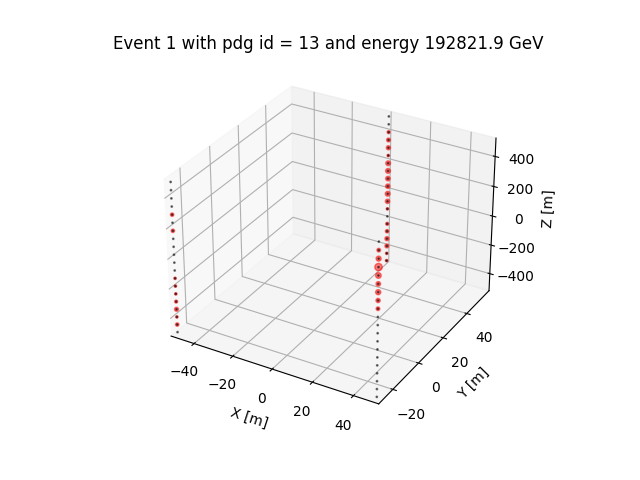

In [ ]:
parquet_sub_plotting(
    example_set,
    e_id=1, det=det,
    channel='photons',
    show_lepton=True,
    scaling=10,
    number_of_hits=1000,
    hitcut=0
)